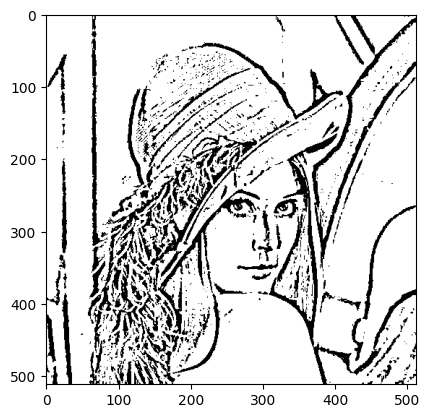

In [102]:
from collections import Counter
import math
from typing import Collection
from matplotlib.image import imread
from enum import Enum
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib.image import imsave
from numpy import ndarray
import matplotlib.pyplot as plt
from itertools import chain
from typing import Optional
import cv2



class ColorModel(Enum):
    rgb = 0
    hsv = 1
    hsi = 2
    hsl = 3
    gray = 4
    sepia = 5


class BaseImage:
    data: np.ndarray
    color_model: ColorModel

    def __init__(self, path: str = None) -> None:
        if path is None:
            self.data = np.array([])
            self.color_model = None
            return
        self.color_model = ColorModel.rgb
        self.data  = imread(path)
        if(isinstance(self.data.flat[0], np.floating)):
            self.data = self.data * 255


    def save_img(self, path: str) -> None:
        imsave(path, self.data)


    def show_img(self) -> None:
        if self.color_model is ColorModel.gray:
                imshow(self.data, cmap='gray')
        else:
            imshow(self.data)


    def get_layer(self, layer_id: int) -> 'BaseImage':
        self.data = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))[layer_id]
        return self.data


    def to_hsv(self) -> 'BaseImage':
        r, g, b = np.float32(np.squeeze(np.dsplit(self.data, self.data.shape[-1])))
        image = self.data.astype(float)
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                R = r[i, j]
                G = g[i, j]
                B = b[i, j]
                M = max(max(R, G), B)
                m = min(min(R, B), G)
                V= M/255
                if M > 0:
                    S = 1- m / M
                else:
                    S = 0
                if G>= B:
                    try:
                        H = np.int16(math.cos((int(R) - 1/2* int(G) - 1/2*int(B))/math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1))
                    except ZeroDivisionError:
                        H = 0
                else:
                    try:
                        H = np.int16(360 - (math.cos((int(R) - (1/2*int(G)) - (1/2*int(B)))/ math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1)))
                    except ZeroDivisionError:
                        H = 0

                image[i,j,0] = H
                image[i,j,1] = S
                image[i,j,2] = V
        self.data = image
        self.color_model= ColorModel.hsv
        return self


    def to_hsi(self) -> 'BaseImage':
        r, g, b = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
        image = self.data.astype(float)
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                R = int(r[i, j])
                G = int(g[i, j])
                B = int(b[i, j])

                m = min(min(R, B), G)
                I = (R+G+B)/3
                if I>255:
                    I = 255
                try:
                    S = 1-(3/(R+G+B)*m)
                except ZeroDivisionError:
                    S = 0

                if G>= B:
                    try:
                        H = np.int16(math.cos((int(R) - 1/2* int(G) - 1/2*int(B))/math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1))
                    except ZeroDivisionError:
                        H = 0
                else:
                    try:
                        H = np.int16(360 - (math.cos((int(R) - (1/2*int(G)) - (1/2*int(B)))/ math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1)))
                    except ZeroDivisionError:
                        H = 0

                image[i,j,0] = H
                image[i,j,1] = S
                image[i,j,2] = I
        self.data = image
        self.color_model= ColorModel.hsi
        return self


    def to_hsl(self) -> 'BaseImage':
        r, g, b = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
        image = self.data.astype(float)
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                R = r[i, j]
                G = g[i, j]
                B = b[i, j]
                M = max(R, G, B)
                m = min(R, B, G)
                d = (M-m)/255
                L = (0.5*(int(M)+int(m)))/255
                if L > 0:
                    if d==0:
                        S=0
                    else:
                        S = d/(1-abs(2 * L - 1))
                else:
                    S = 0

                if G>= B:
                    try:
                        H = np.int16(math.cos((int(R) - 1/2* int(G) - 1/2*int(B))/math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1))
                    except ZeroDivisionError:
                        H = 0
                else:
                    try:
                        H = np.int16(360 - (math.cos((int(R) - (1/2*int(G)) - (1/2*int(B)))/ math.sqrt(int(R)*int(R)+ int(G)*int(G)+ int(B)*int(B) - int(R)*int(G) - int(R)*int(B) - int(G)*int(B))) ** (-1)))
                    except ZeroDivisionError:
                        H = 0

                image[i,j,0] = H
                image[i,j,1] = S
                image[i,j,2] = L
        self.data = image
        self.color_model= ColorModel.hsl
        return self


    def to_rgb(self) -> 'BaseImage':
        if self.color_model == ColorModel.hsv:
            h,s,v = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
            image = self.data.astype(float)
            for i in range(self.data.shape[0]):
                for j in range(self.data.shape[1]):
                    H = h[i, j]
                    S = s[i, j]
                    V = v[i, j]
                    M= 255* V
                    m=M*(1 - S)
                    z = (M- m) * (1- abs(((H/60) % 2) - 1))
                    if 0 <= H < 60:
                        R = M
                        G = z+m
                        B= m
                    elif 60 <= H < 120:
                        R = z+m
                        G = M
                        B = m
                    elif 120 <= H < 180:
                        R = m
                        G = M
                        B = z + m
                    elif 180 <= H < 240:
                        R = m
                        G = M
                        B = z + m
                    elif 240 <= H < 300:
                        R = z + m
                        G = m
                        B = M
                    elif 300 <= H < 360:
                        R = M
                        G= m
                        B = z + m
                    image[i,j,0] = R
                    image[i,j,1] = G
                    image[i,j,2] = B
            self.data = np.uint8(image)
            return self

        elif self.color_model == ColorModel.hsi:
            h,s,z = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
            image = self.data.astype(float)
            for i in range(self.data.shape[0]):
                for j in range(self.data.shape[1]):
                    H = h[i, j]
                    S = s[i, j]
                    I = z[i, j]

                    if 0 < H <= 120 :
                        B = I * (1 - S)
                        R = I * (1 + (S * math.cos(math.radians(H)) / math.cos(math.radians(60) - math.radians(H))))
                        G = I * 3 - (R + B)
                    elif 120 < H <= 240:
                        H -= 120
                        R = I * (1 - S)
                        G = I * (1 + (S * math.cos(math.radians(H)) / math.cos(math.radians(60) - math.radians(H))))
                        B = 3 * I - (R + G)
                    elif 0 < H <= 360:
                        H -= 240
                        G = I * (1 - S)
                        B = I * (1 + (S * math.cos(math.radians(H)) / math.cos(math.radians(60) - math.radians(H))))
                        R = I * 3 - (G + B)
                    image[i,j,0] = R
                    image[i,j,1] = G
                    image[i,j,2] = B

            self.data = np.uint8(image)
            return self


        elif self.color_model== ColorModel.hsl:
            h,s,l = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
            image = self.data.astype(float)
            for i in range(self.data.shape[0]):
                for j in range(self.data.shape[1]):
                    H = h[i, j]
                    S = s[i, j]
                    L = l[i, j]
                    d = S* ( 1- abs(2* L - 1))
                    m = 255*(L - 0.5 * d)
                    x = d*(1- abs(((H/60)%2) - 1))
                    if 0 <= H <60:
                        R = 255*d+m
                        G = 255 * x +m
                        B = m
                    if 60 <= H < 120:
                        R = 255 * x * m
                        G = 255* d +m
                        B = m
                    if 120 <= H <180:
                        R = m
                        G = 255 * d + m
                        B = 255 * x + m
                    if 180 <= H < 240:
                        R = m
                        G = 255 * x + m
                        B = 255*d +m
                    if 240<= H <300:
                        R = 255*x+m
                        G = m
                        B = 255* d +m
                    if 300<=H <360:
                        R= 255* d + m
                        G = m
                        B = 255*x +m
                    image[i,j,0] = R
                    image[i,j,1] = G
                    image[i,j,2] = B
            self.data = np.uint8(image)
            return self



class GrayScaleTransform(BaseImage):
    def __init__(self, path: str=None) -> None:
        super().__init__(path)


    def to_gray(self) -> 'Image':
        r, g, b = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
        image = self.data.astype(int)
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                R = int(r[i, j])
                G = int(g[i, j])
                B = int(b[i, j])
                gray=(R+G+B)/3
                image[i,j] = gray
        self.data = image
        self.color_model = ColorModel.gray
        return self


    def to_sepia(self,alpha_beta:tuple = (None,None), w:int = None) -> BaseImage:
        r, g, b = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
        image = self.data.astype(int)
        for i in range(self.data.shape[0]):
            val_err = False
            for j in range(self.data.shape[0]):
                R = int(r[i, j])
                G = int(g[i, j])
                B = int(b[i, j])
                gray=(R+G+B)/3
                image[i,j] = gray
                if alpha_beta:
                    if(alpha_beta[0]<=1 or alpha_beta[1]>=1 or alpha_beta[0]+alpha_beta[1]!=2):
                        print("Alfa powinna byc wieksza niz 1, beta mniejsza niz 1, a ich suma powinna wynosic 2")
                        val_err = True
                        break
                    else:
                        L0 = image[i,j,0] *float(alpha_beta[0])
                        L1 = image[i,j,1]
                        L2 = image[i,j,2] *float(alpha_beta[1])
                        if L0>255:
                            L0 = 255
                        if L1>255:
                            L1 = 255
                        if L2>255:
                            L2 = 255
                        image[i,j] = np.dstack((L0,L1,L2))
                if w:
                    if(w<20 or w>40):
                        print("W powinno byc wieksze niz 20 oraz mniejsze od 40")
                        val_err = True
                        break
                    else:
                        L0 = image[i,j,0] + 2 * w
                        L1 = image[i,j,1] + w
                        L2 = image[i,j,2]
                        if L0>255:
                            L0 = 255
                        if L1>255:
                            L1 = 255
                        if L2>255:
                            L2 = 255
                        image[i,j] = np.dstack((L0,L1,L2))

            if val_err:
                break

        self.data = image
        self.color_model = ColorModel.sepia
        return self



class Histogram:
    values: np.ndarray

    def __init__(self, values: np.ndarray) -> None:
        self.values = values

        if(isinstance(self.values.flat[0], np.floating)):
            self.values = self.values /255


    def plot(self) -> None:

        r, g, b = np.squeeze(np.dsplit(self.values, self.values.shape[-1]))

        x = np.array(range(256))
        plt.subplot(1,3,1)
        plt.title("histogram of Red")
        plt.hist(r*255,bins=x, range=[0,255], color='red',histtype='step')

        plt.subplot(1,3,2)
        plt.title("histogram of Green")
        plt.hist(g*255,bins=x, range=[0,255], color='green',histtype='step')

        plt.subplot(1,3,3)
        plt.title("histogram of Blue")
        plt.hist(b*255,bins=x, range=[0,255], color='blue',histtype='step')

        plt.tight_layout()
        plt.show()



    def to_cumulated(self) -> 'Histogram':

        r, g, b = np.squeeze(np.dsplit(self.values, self.values.shape[-1]))
        r= r.flatten()
        g = g.flatten()
        b= b.flatten()

        x = np.array(range(256))
        plt.subplot(1,3,1)
        plt.title("cumulative of Red")
        plt.hist(r,bins=x, range=[0,255], color='red',histtype='bar',cumulative=True)
        plt.xlim([np.min(r),np.max(r)])
        plt.rcParams["figure.figsize"] = (10,7)
        plt.subplot(1,3,2)
        plt.title("cumulative of Green")
        plt.hist(g,bins=x, range=[0,255], color='green',histtype='bar',cumulative=True)
        plt.xlim([np.min(g),np.max(g)])
        plt.rcParams["figure.figsize"] = (10,7)
        plt.subplot(1,3,3)
        plt.title("cumulative of Blue")
        plt.hist(b,bins=x, range=[0,255], color='blue',histtype='bar',cumulative=True)
        plt.xlim([np.min(b),np.max(b)])
        plt.rcParams["figure.figsize"] = (10,7)

        plt.tight_layout()
        plt.show()
        return


class ImageDiffMethod(Enum):
    mse= 0
    rmse = 1

class ImageComparison(BaseImage):

    def histogram(self) -> Histogram:
        r, g, b = np.squeeze(np.dsplit(self.data, self.data.shape[-1]))
        r = r.flatten()
        g = g.flatten()
        b = b.flatten()

        return Histogram(np.dstack((r,g,b)))


    def compare_to(self, other: 'Image', method: ImageDiffMethod) -> float:
        origin = self.to_gray()
        other = other.to_gray()
        MSE = np.square(np.subtract(origin.data,other.data)).mean()
        if(method is ImageDiffMethod.mse):
            return MSE
        else:
            RMSE = math.sqrt(MSE)
            return RMSE




class ImageAligning(BaseImage):

    def __init__(self, path: str) -> None:
        super().__init__(path)

    def align_image(self,tail_elimination: bool = True) -> 'BaseImage':

        image  = self.data.astype(float)

        r, g, b = np.squeeze(np.dsplit(image, image.shape[-1]))
        min = np.min(r)
        max = np.max(r)
        for x, y in np.ndindex(r.shape):
                result = ((image[x,y,0]-min)/(max-min))*255
                image[x,y,0] = result

        min = np.min(g)
        max = np.max(g)
        for x, y in np.ndindex(g.shape):
                result = ((image[x,y,1]-min)/(max-min))*255
                image[x,y,1] = result

        min = np.min(b)
        max = np.max(b)
        for x, y in np.ndindex(b.shape):
                result = ((image[x,y,2]-min)/(max-min))*255
                image[x,y,2] = result


        if tail_elimination == True:
            hr, hg, hb = np.squeeze(np.dsplit(image.data, image.data.shape[-1]))

            histr, bin_edgesr = np.histogram(hr, range=(0,255),bins=256)
            histg, bin_edgesg = np.histogram(hg, range=(0,255),bins=256)
            histb, bin_edgesb = np.histogram(hb, range=(0,255),bins=256)

            minr = np.argwhere(histr[histr>np.percentile(histr,0.05)])[0]
            maxr = np.argwhere(histr[histr>np.percentile(histr,0.95)])[-1]
            for x, y in np.ndindex(hr.shape):
                result = ((image[x,y,0]-minr)/(maxr-minr))*255
                image[x,y,0] = result

            ming = np.argwhere(histg[histg>np.percentile(histg,0.05)])[0]
            maxg = np.argwhere(histg[histg>np.percentile(histg,0.95)])[-1]
            for x, y in np.ndindex(hg.shape):
                    result = ((image[x,y,1]-ming)/(maxg-ming))*255
                    image[x,y,1] = result

            minb = np.argwhere(histb[histb>np.percentile(histb,0.05)])[0]
            maxb = np.argwhere(histb[histb>np.percentile(histb,0.95)])[-1]
            for x, y in np.ndindex(hb.shape):
                    result = ((image[x,y,2]-minb)/(maxb-minb))*255
                    image[x,y,2] = result


            image[image > 255] = 255
            image[image < 0] = 0
            self.data = image.astype(np.uint8)
            return self
        else:
            image[image > 255] = 255
            image[image < 0] = 0
            self.data = image.astype(np.uint8)
            return self





class ImageFiltration:
    def conv_2d(self, image: BaseImage, kernel: np.ndarray, prefix: Optional[float] = 1) -> 'BaseImage':
        kernel = kernel * prefix
        image = self.data.astype(float)
        kernel = np.repeat(np.expand_dims(kernel, axis=-1), self.data.shape[-1], axis=-1)
        kernel_x, kernel_y = kernel.shape[:2]

        for x in range(self.data.shape[0] - kernel_x + 1):
            for y in range(self.data.shape[1] - kernel_y + 1):
                picture = self.data[x:x + kernel_x, y:y + kernel_y]
                result = np.sum(kernel * picture, axis=(0, 1))
                image[x, y] = result

        image[image > 255] = 255
        image[image < 0] = 0
        self.data = image.astype(np.uint8)
        return self


class Thresholding(BaseImage):
    def threshold(self, value: int) -> BaseImage:
        image  = self.data.astype(np.uint8)
        image[image < value] = 0
        image[image >= value] = 255
        self.data = image.astype(np.uint8)
        return self

class OpenMethods:
    def otsu(self,threshold_val: int):
        self.to_gray()
        self.threshold(threshold_val)
        return self

    def adaptive(path: str):
        lena_gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        th_adaptive = cv2.adaptiveThreshold(
            lena_gray,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
            thresholdType=cv2.THRESH_BINARY,
            blockSize=13,
            C=8
        )
        plt.imshow(th_adaptive, cmap='gray')




class Image(GrayScaleTransform,ImageComparison, ImageAligning, ImageFiltration,Thresholding):
    def __init__(self, path: str=None) -> None:
        super().__init__(path)


img = OpenMethods
img.adaptive('lena.jpg')

In [ ]:
#lab2
a=Image('moderncity.jpg')
# print(a.data)
a.to_hsv()
# a.to_hsi()
# a.to_hsl()
a.to_rgb()
a.show_img()

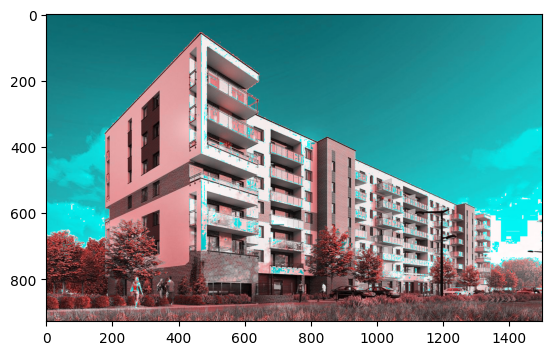

In [11]:
#lab2
a=Image('moderncity.jpg')
# print(a.data)
# a.to_hsv()
a.to_hsi()
# a.to_hsl()
a.to_rgb()
a.show_img()

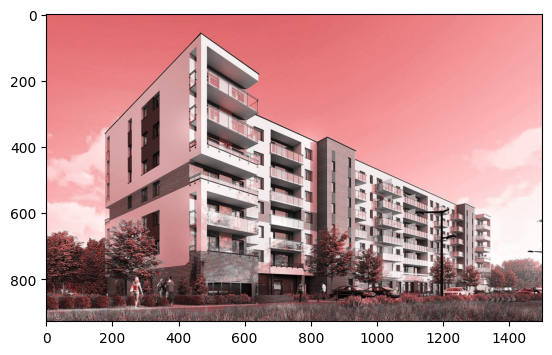

In [12]:
`#lab2
a=Image('moderncity.jpg')
# print(a.data)
# a.to_hsv()
# a.to_hsi()
a.to_hsl()
a.to_rgb()
a.show_img()`

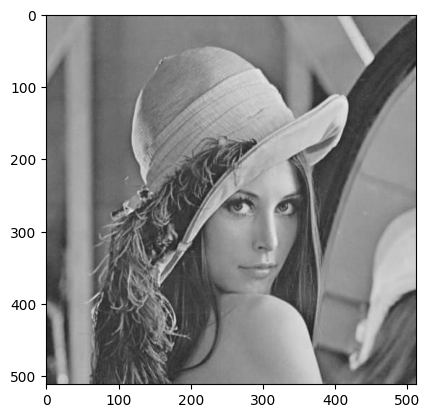

In [13]:
#lab3
img=Image('lena.jpg')
a=img.to_gray()
# a=img.to_sepia([1.5,0.5],w=None)
# a=img.to_sepia(alpha_beta=None,w=20)
# print(a.data)
a.show_img()

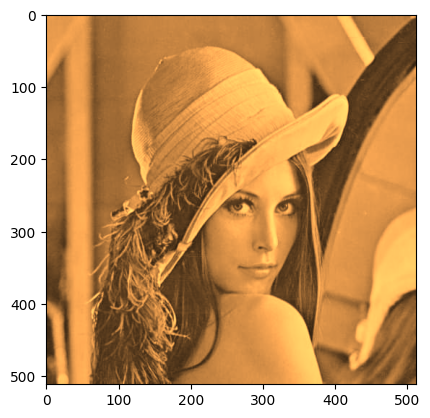

In [14]:
`#lab3
img=Image('lena.jpg')
# a=img.to_gray()
a=img.to_sepia([1.5,0.5],w=None)
# a=img.to_sepia(alpha_beta=None,w=20)
# print(a.data)
a.show_img()`

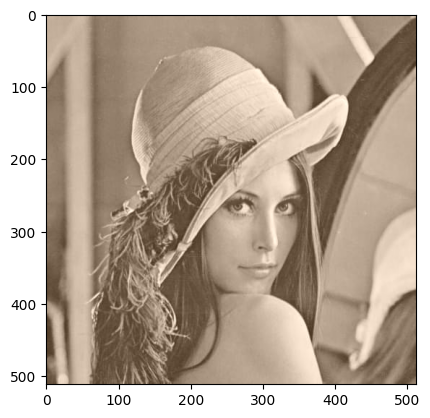

In [15]:
#lab3
img=Image('lena.jpg')
# a=img.to_gray()
# a=img.to_sepia([1.5,0.5],w=None)
a=img.to_sepia(alpha_beta=None,w=20)
# print(a.data)
a.show_img()

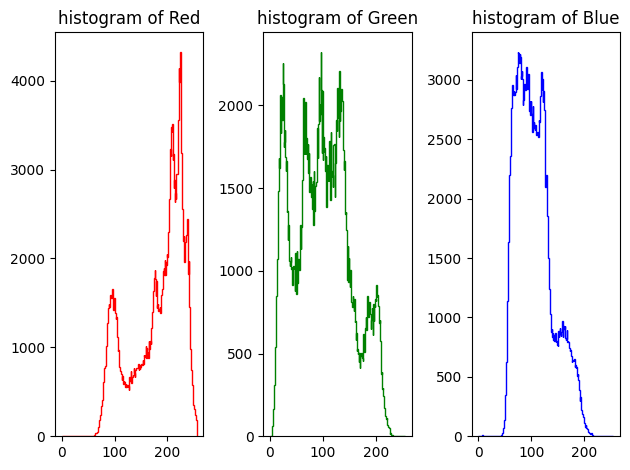

0.0
76.31552505493164
734.0751838684082
7696.424144744873
17896.42444229126
 ---------- 
0.0
8.73587574630796
27.093821876368942
87.72926618150224
133.77751844869624


In [16]:
#lab4
lena_hist=Image('lena.png')
lena_hist = lena_hist.histogram()
lena_hist.plot()

lena=Image('lena.jpg')
box=Image('box.jpg')
lena_box=Image('lena_box.jpg')
lena_star=Image('lena_star.jpg')
lena_star2=Image('lena_star2.jpg')

print(lena.compare_to(lena,ImageDiffMethod.mse))
print(lena.compare_to(lena_star,ImageDiffMethod.mse))
print(lena.compare_to(lena_star2,ImageDiffMethod.mse))
print(lena.compare_to(lena_box,ImageDiffMethod.mse))
print(lena.compare_to(box,ImageDiffMethod.mse))
print(" ---------- ")
print(lena.compare_to(lena,ImageDiffMethod.rmse))
print(lena.compare_to(lena_star,ImageDiffMethod.rmse))
print(lena.compare_to(lena_star2,ImageDiffMethod.rmse))
print(lena.compare_to(lena_box,ImageDiffMethod.rmse))
print(lena.compare_to(box,ImageDiffMethod.rmse))

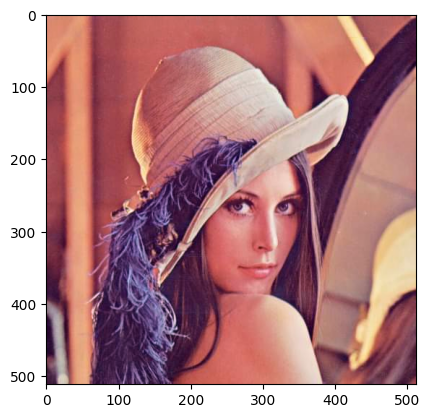

In [17]:
#lab5
lena = Image('lena.jpg')
# lena = lena.to_gray()
# print(lena.data.shape)
lena = lena.align_image(False)
# print(lena.data)
# lena = lena.align_image(True)
# lena = lena.histogram()
# lena.plot()
# print(lena.data.shape)
# imshow(lena.data)
lena.show_img()

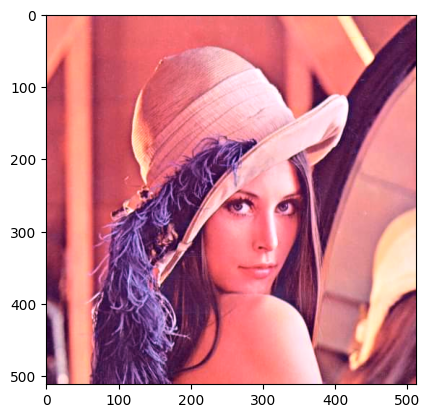

In [18]:
#lab5
lena = Image('lena.jpg')
# lena = lena.to_gray()
# print(lena.data.shape)
# lena = lena.align_image(False)
# print(lena.data)
lena = lena.align_image(True)
# lena = lena.histogram()
# lena.plot()
# print(lena.data.shape)
# imshow(lena.data)
lena.show_img()

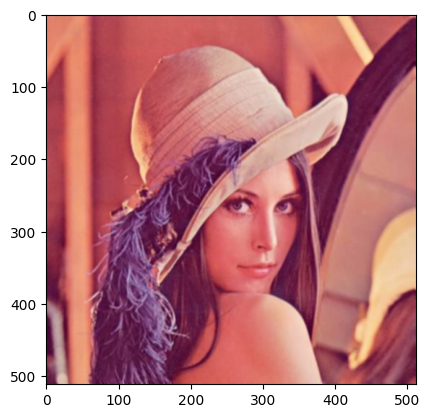

In [19]:
#lab6
lena = Image('lena.jpg')
# lena = lena.data.astype(np.uint8)
# print(lena.data)

# filtr = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) # wyostrzajacy bez prefixu
filtr = np.array([[1,2,1],[2,4,2],[1,2,1]]) # rozmyty prefix=1/16
lena = lena.conv_2d(lena,filtr,prefix=1/16)

# imshow(lena.data)
lena.show_img()

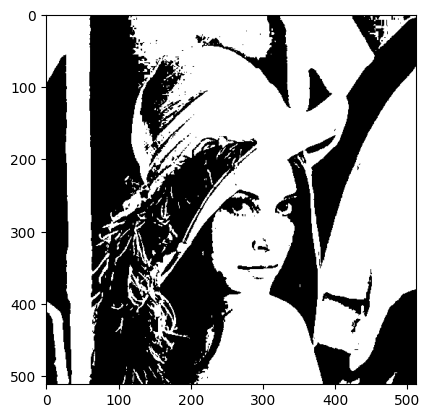

In [20]:
#lab7
lena = Image('lena.jpg')
# print(lena.data)
lena.to_gray()
lena.threshold(127)
# print(lena.data)
# imshow(lena.data)
lena.show_img()